In [1]:
import pandas as pd
import numpy as np
import scipy
import statsmodels 
from statsmodels.tsa import stattools

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from statannotations.Annotator import Annotator

from ssm_stats import EsmssmStats
stats = EsmssmStats()
from ssm_prep_data import EsmssmDataPrep
prep = EsmssmDataPrep()
from ssm_plotting import EsmssmPlotting
plotting = EsmssmPlotting()

# Define filepath
filepath = '../../results/modelfits/'

# Define path to save figures
figpath = '../../results/paper_figures/'
savefig = False

In [2]:
# Load leemput dataset
df = pd.read_csv(filepath + '../../data/data_prep/leemput/mooddata.csv', delimiter=',')

# Load modelfit for leemput dataset
mat = scipy.io.loadmat(filepath + 'leemput/ssmfit.mat')

# Number of subjects
Nsj = len(mat['fit'][0])

# Define dimensions
mood_columns = ['cheerful', 'content', 'anxious', 'sad']

# Define dynamic matrix labels
A_columns = [mood_columns[j] + r' $\rightarrow$ ' + mood_columns[i] for i in range(4) for j in range(4)]
A_columns_idx = [mood_columns[j] + r' $\rightarrow$ ' + mood_columns[i] + r' (a$_{' + \
                 str(i+1) + str(j+1) + '}$)' for i in range(4) for j in range(4)]

In [3]:
# Extract parameter estimates from mat file
data = []
for i in range(Nsj):
    subdata = dict()
    subdata['timing'] = mat['fit'][0][i][0][0][2]
    subdata['numberMeasurements'] = len(subdata['timing'])
    subdata['data'] = mat['fit'][0][i][0][0][3]
    subdata['datamean'] = np.nanmean(subdata['data'],1)
    subdata['A'] = mat['fit'][0][i][0][0][5]['A'][0][0] + mat['fit'][0][i][0][0][5]['W'][0][0]
    subdata['bias'] = mat['fit'][0][i][0][0][5]['h'][0][0]
    subdata['latents'] = mat['fit'][0][i][0][0][5]['z'][0][0]
    subdata['dynamics'] = dict()
    subdata['dynamics']['val'], subdata['dynamics']['vec'] = stats.eig_dynamics_features(subdata['A'])
    data.append(subdata)

In [4]:
# Sort depression data for patients and controls
df_depression = df[['dep1', 'dep2', 'change', 'group', 'id']].groupby('id').mean().reset_index()

for i in ['dep1', 'dep2', 'change']:
    for g in range(2):
        df_depression.loc[df_depression['group']==g, i + '_zscore'] = \
            scipy.stats.zscore(df_depression[i][df_depression['group']==g], nan_policy='omit')

print('number of patients = ' + str(sum(df_depression['group']==0)) + \
     ' and controls = ' + str(sum(df_depression['group']==1)))

number of patients = 117 and controls = 210


In [5]:
# Exclusion of subjects
df_exclusion = pd.read_csv('../../data/data_prep/leemput/exclusioncode.csv')
no_data = sum(df_exclusion['exclusion_code'][df_exclusion['group']==1] == 1)
print('total: ' + str(len(df_exclusion['exclusion_code'])-no_data))
for i in range(2):
    print(['patients: ','controls: '][i] + \
          str(len(df_exclusion['exclusion_code'][df_exclusion['group']==i])-i*no_data))


total: 402
patients: 33
controls: 369


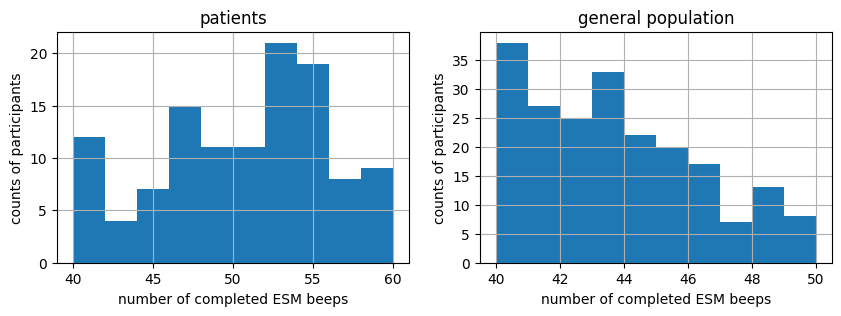

In [6]:
# Plot histograms for number of completed beeps
fig, ax = plt.subplots(1,2,figsize=(10,3))
for i in range(2):
    df['id'][df['group']==i].value_counts().hist(ax=ax[i])
    ax[i].set(title=['patients', 'general population'][i], xlabel='number of completed ESM beeps', ylabel='counts of participants')

In [7]:
# Summary statistics of patients and controls
df_summary_stats = pd.DataFrame()
for i in range(2):
    df_summary_stats.loc[0,i] = str(df['id'][df['group']==i].value_counts().mean().round()) + ' ± ' + \
                                     str(df['id'][df['group']==i].value_counts().std().round())
    means = df[[j for j in df.columns if 'mood' in j]+['id', 'dep1', 'dep2']][df['group']==i].groupby('id').mean().mean().round(2)
    stds = df[ [j for j in df.columns if 'mood' in j]+['id', 'dep1', 'dep2']][df['group']==i].groupby('id').mean().std().round(2)
    for k in range(len(means)):
        df_summary_stats.loc[k+1,i] = str(means[k]) + ' ± ' + str(stds[k])
df_summary_stats.columns = ['patients (N=' + str(sum(df_depression['group']==0)) + ')', \
                         'general population (N=' + str(sum(df_depression['group']==1)) + ')']
df_summary_stats.index = ['# of measurments'] + mood_columns + ['depression_baseline', 'depression_followup']
df_summary_stats

,patients (N=117),general population (N=210)
# of measurments,50.0 ± 5.0,43.0 ± 3.0
cheerful,2.87 ± 1.55,4.68 ± 0.95
content,3.06 ± 1.59,4.85 ± 0.93
anxious,1.68 ± 1.23,1.18 ± 0.29
sad,2.36 ± 1.39,1.32 ± 0.46
depression_baseline,23.78 ± 3.67,1.4 ± 0.45
depression_followup,12.49 ± 6.84,1.46 ± 0.53


In [8]:
# Extract dynamics features
dynamics, basic_char = prep.extract_dynamic_features(data)

# Group differences of dynamics matrix elements (hourly)

In [9]:
# Test for normality in variables
normality_assumption = stats.test_normality(dynamics['matrix_hour'])
        
print(str(sum(normality_assumption)) + ' out of ' +  str(np.prod(np.shape(dynamics['matrix_hour'][:,:,0]))) + ' are normal, \
therefore use a Mann Whitney U Test for group comparison')

1 out of 16 are normal, therefore use a Mann Whitney U Test for group comparison


In [10]:
# Table of group difference of matrix elements 
parameter = np.reshape(dynamics['matrix_hour'], (16, Nsj))
df_stats_dynamics = stats.group_difference_table(parameter, df_depression, 'MWU', \
                       ['patients (M ± SD)', 'controls (M ± SD)', 'U', 'pvalue'], A_columns_idx)

display(df_stats_dynamics)
# print(df_stats_dynamics.to_latex(escape=False))

multiple comparison: p<0.025


,patients (M ± SD),controls (M ± SD),U,pvalue
cheerful $\rightarrow$ cheerful (a$_{11}$),0.35 ± 0.36,0.32 ± 0.46,12607.0,0.695
content $\rightarrow$ cheerful (a$_{12}$),0.08 ± 0.41,0.22 ± 0.47,9659.0,0.001
anxious $\rightarrow$ cheerful (a$_{13}$),0.03 ± 0.29,-0.02 ± 0.36,13173.0,0.279
sad $\rightarrow$ cheerful (a$_{14}$),-0.15 ± 0.4,-0.04 ± 0.42,10293.0,0.015
cheerful $\rightarrow$ content (a$_{21}$),0.17 ± 0.36,0.13 ± 0.52,13345.0,0.196
content $\rightarrow$ content (a$_{22}$),0.3 ± 0.38,0.38 ± 0.45,10276.0,0.014
anxious $\rightarrow$ content (a$_{23}$),0.03 ± 0.27,-0.04 ± 0.38,13494.0,0.14
sad $\rightarrow$ content (a$_{24}$),-0.13 ± 0.37,-0.04 ± 0.45,9536.0,$<$0.001
cheerful $\rightarrow$ anxious (a$_{31}$),0.01 ± 0.24,0.01 ± 0.21,12269.0,0.985
content $\rightarrow$ anxious (a$_{32}$),-0.02 ± 0.22,-0.04 ± 0.22,12429.0,0.861


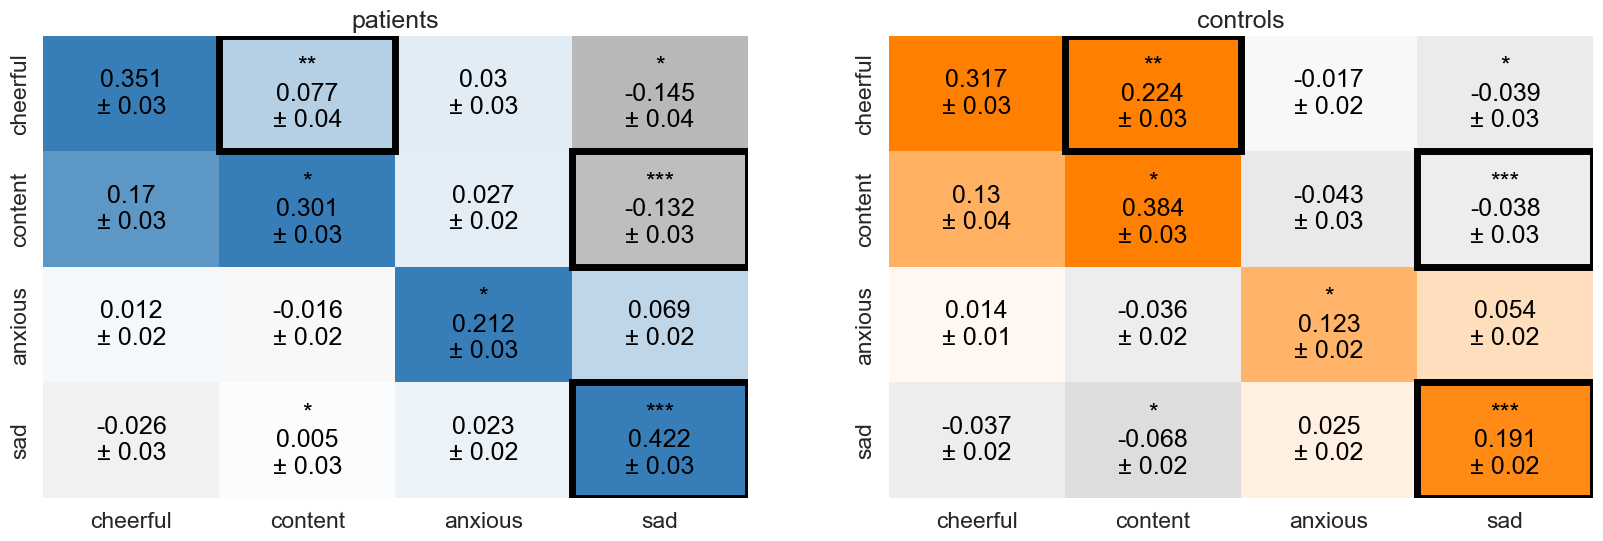

In [11]:
# Plot average dynamic matrix (h) for patients and control including statistics
opt_plot = dict()
sns.set(font_scale=1.5)
group_color, negpos_color, minusplus_color, patients_shading, controls_shading = plotting.color_definition()
fig,ax = plt.subplots(1,2, figsize=(20,6))
opt_plot['fig'] = fig
opt_plot['ax'] = ax
opt_plot['xlabels'] = mood_columns
opt_plot['group_label'] = ['patients', 'controls']
opt_plot['cmap'] = [patients_shading, controls_shading]
opt_plot['color'] = group_color
opt_plot['parameteric'] = True
parameter = np.reshape(dynamics['matrix_hour'], (16, Nsj))
idx = ~np.isnan(parameter).any(axis=0)
[U,p] = scipy.stats.mannwhitneyu(parameter[:,(df_depression['group']==0)&idx].T, \
                              parameter[:,(df_depression['group']==1)&idx].T)
plotting.plot_dynamics_matrices_group(np.real(dynamics['matrix_hour']), df_depression['group'], p, opt_plot)
if savefig: plt.savefig(figpath + 'leemput_fig1_DynamicsMatrix.png')

An anticipated symmetrical pattern emerges among controls, where items of similar valence boost each other, while those of opposing valence counteract each other. However, this pattern is not observed to the same extent among patients.

In [12]:
# Regression between matrix items and depression score separate for both groups
score ='dep1_zscore'
parameter = np.reshape(dynamics['matrix_hour'], (16, Nsj))
df_reg_matrix = pd.DataFrame()
for g in range(2):
    tmp = stats.depression_relations(parameter[:,df_depression['group']==g], df_depression[score][df_depression['group']==g], \
                            ['rspear', 'pvalue'], A_columns_idx)
    df_reg_matrix = pd.concat((df_reg_matrix,tmp),axis=1)
header = [np.repeat(np.array(['patients', 'controls']),len(df_reg_matrix.columns.unique())), \
          np.array(len(['patients', 'controls'])*['rspear', 'pvalue']).flatten()]
df_reg_matrix.columns = header
display(df_reg_matrix)
# print(df_reg_matrix.to_latex(escape=False))

patients        controls          
                                             rspear pvalue   rspear    pvalue
cheerful $\rightarrow$ cheerful (a$_{11}$)    -0.05  0.643     0.04     0.558
content $\rightarrow$ cheerful (a$_{12}$)      0.00  0.975     0.02      0.76
anxious $\rightarrow$ cheerful (a$_{13}$)     -0.16  0.148    -0.04     0.554
sad $\rightarrow$ cheerful (a$_{14}$)          0.09  0.434    -0.08     0.273
cheerful $\rightarrow$ content (a$_{21}$)     -0.02  0.885    -0.06     0.352
content $\rightarrow$ content (a$_{22}$)      -0.04  0.724     0.06     0.361
anxious $\rightarrow$ content (a$_{23}$)      -0.20  0.069    -0.10     0.135
sad $\rightarrow$ content (a$_{24}$)           0.18  0.107    -0.08     0.253
cheerful $\rightarrow$ anxious (a$_{31}$)      0.05  0.633     0.14     0.051
content $\rightarrow$ anxious (a$_{32}$)      -0.18  0.104    -0.13     0.071
anxious $\rightarrow$ anxious (a$_{33}$)       0.10  0.389     0.21     0.003
sad $\rightarrow$ anxious (a$_{34}$)          -0.00  0.974     0.01     0.885
cheerful $\rightarrow$ sad (a$_{41}$)          0.02  0.832    -0.03     0.674
content $\rightarrow$ sad (a$_{42}$)          -0.11  0.326    -0.07     0.321
anxious $\rightarrow$ sad (a$_{43}$)           0.13  0.266     0.13     0.057
sad $\rightarrow$ sad (a$_{44}$)               0.09  0.409     0.29  $<$0.001

Eigenspectrum of dynamics matrix:
---

In [13]:
# group differences of different dynamical feature
parameter_labels = ['eigenvalues', 'eigenvector', 'variabilty', 'instability', 'inertia', 'mean']
par = [dynamics['val'], (dynamics['vec_aligned'][:,0,:]), \
                      basic_char['variance'], basic_char['RMSSD'], basic_char['AR'], basic_char['mean']]
for j, i in enumerate(par):
    normality_assumption = stats.test_normality(scipy.stats.zscore(i))

    print(parameter_labels[j] + ': ' + str(sum(normality_assumption)) + ' out of ' +  str(4) + ' are parametric')
print('Therefore we use a Mann Whitney U Test for group comparison')

eigenvalues: 0 out of 4 are parametric
eigenvector: 0 out of 4 are parametric
variabilty: 0 out of 4 are parametric
instability: 4 out of 4 are parametric
inertia: 4 out of 4 are parametric
mean: 0 out of 4 are parametric
Therefore we use a Mann Whitney U Test for group comparison


In [14]:
print('multiple comparison ' + str(0.05/4))
df_stats_eigenspectrum = pd.DataFrame(columns=['T2', 'Fstats', 'pvalue'])
for i in range(4):
    [T2, tstats, pval] = stats.TwoSampleT2Test(np.abs(dynamics['vec'][:,i,df_depression['group']==0]).T, \
                                   np.abs(dynamics['vec'][:,i,df_depression['group']==1]).T)
    df_stats_eigenspectrum.loc[i] = [np.round(T2,2), np.round(tstats,2), pval]
df_stats_eigenspectrum = stats.replace_small_pvalues(df_stats_eigenspectrum)
df_stats_eigenspectrum.index = [str(i+1) + '. eigenvector' for i in range(4)]
display(df_stats_eigenspectrum)
# print(df_stats_eigenspectrum.to_latex())

multiple comparison 0.0125


,T2,Fstats,pvalue
1. eigenvector,36.02,8.92,$<$0.001
2. eigenvector,22.06,5.46,$<$0.001
3. eigenvector,3.88,0.96,0.429
4. eigenvector,16.96,4.20,0.002


In [15]:
# Group difference of eigenvectors
positive = np.nanmean(dynamics['vec_aligned'][:2,0,:],0)
pos_stats = stats.group_difference_table(positive, df_depression, 'MWU', \
                       ['patients (M ± SD)', 'controls (M ± SD)', 'U', 'pvalue'])
negative = np.nanmean(dynamics['vec_aligned'][2:,0,:],0)
neg_stats = stats.group_difference_table(negative, df_depression, 'MWU', \
                       ['patients (M ± SD)', 'controls (M ± SD)', 'U', 'pvalue'])
diff_stats = stats.group_difference_table(np.abs(positive - negative), df_depression, 'MWU', \
                       ['patients (M ± SD)', 'controls (M ± SD)', 'U', 'pvalue'])
df_pos_neg_diff = pd.concat((pos_stats, neg_stats, diff_stats),axis=0)
df_pos_neg_diff.index = ['positive', 'negative', 'diff']
df_pos_neg_diff

multiple comparison: p<0.05
multiple comparison: p<0.05
multiple comparison: p<0.05


,patients (M ± SD),controls (M ± SD),U,pvalue
positive,0.4 ± 0.28,0.53 ± 0.21,9048.0,$<$0.001
negative,-0.26 ± 0.26,-0.16 ± 0.21,9379.0,$<$0.001
diff,0.65 ± 0.19,0.69 ± 0.18,11096.0,0.147


In [16]:
# Group differences of different dynamical features
parameter_labels = ['eigenvalues', 'slowest eigenvector', 'variabilty', 'instability', 'inertia', 'mean']
par = [dynamics['val'], dynamics['stab'], dynamics['vec_aligned'][:,0,:], \
                      basic_char['variance'], basic_char['RMSSD'], basic_char['AR'], basic_char['mean']]

df_stats_dynamics = pd.DataFrame()
for parameter in par:
    
    tmp = stats.group_difference_table(parameter, df_depression, 'MWU', \
                           ['patients (M ± SD)', 'controls (M ± SD)', 'U', 'pvalue'])

    df_stats_dynamics = pd.concat((df_stats_dynamics, tmp), axis=0)
    
header = [np.concatenate((np.repeat(np.array(parameter_labels[0]),5),np.repeat(np.array(parameter_labels[1:]),4))), 
                    np.concatenate((np.array(['1st', '2nd', '3rd', '4th','overall stability']), \
                                    np.array(len(parameter_labels[1:])*mood_columns)))]
df_stats_dynamics.index = header
display(df_stats_dynamics)
# print(df_stats_dynamics.to_latex(escape=False))

multiple comparison: p<0.025
multiple comparison: p<0.05
multiple comparison: p<0.025
multiple comparison: p<0.025
multiple comparison: p<0.025
multiple comparison: p<0.025
multiple comparison: p<0.025


patients (M ± SD) controls (M ± SD)  \
eigenvalues         1st                     0.99 ± 0.01       0.99 ± 0.01   
                    2nd                     0.97 ± 0.08       0.98 ± 0.02   
                    3rd                     0.87 ± 0.25       0.85 ± 0.27   
                    4th                     0.68 ± 0.33       0.66 ± 0.33   
                    overall stability       0.63 ± 0.36       0.59 ± 0.37   
slowest eigenvector cheerful                0.39 ± 0.35        0.54 ± 0.3   
                    content                  0.4 ± 0.32       0.53 ± 0.28   
                    anxious                -0.16 ± 0.32      -0.09 ± 0.24   
                    sad                    -0.36 ± 0.39      -0.22 ± 0.31   
variabilty          cheerful                0.86 ± 0.66       1.16 ± 0.82   
                    content                 0.86 ± 0.72       1.37 ± 0.94   
                    anxious                 0.57 ± 0.98        0.4 ± 0.61   
                    sad                      0.94 ± 0.9       0.61 ± 0.81   
instability         cheerful                 0.0 ± 0.04       -0.0 ± 0.04   
                    content                 -0.0 ± 0.03       -0.0 ± 0.04   
                    anxious                  0.0 ± 0.03       -0.0 ± 0.02   
                    sad                     -0.0 ± 0.03       -0.0 ± 0.03   
inertia             cheerful                0.25 ± 0.21       0.23 ± 0.18   
                    content                 0.24 ± 0.21       0.21 ± 0.18   
                    anxious                  0.2 ± 0.23        0.07 ± 0.2   
                    sad                     0.29 ± 0.21       0.22 ± 0.25   
mean                cheerful                2.87 ± 1.55       4.68 ± 0.95   
                    content                 3.06 ± 1.59       4.85 ± 0.93   
                    anxious                 1.68 ± 1.22       1.18 ± 0.29   
                    sad                     2.36 ± 1.38       1.32 ± 0.46   

                                             U    pvalue  
eigenvalues         1st                13886.0     0.051  
                    2nd                13298.0     0.217  
                    3rd                14261.0     0.016  
                    4th                13520.0     0.132  
                    overall stability  13524.0     0.131  
slowest eigenvector cheerful            9215.0  $<$0.001  
                    content             9599.0     0.001  
                    anxious            11654.0     0.442  
                    sad                 9738.0     0.002  
variabilty          cheerful            9443.0  $<$0.001  
                    content             7740.0  $<$0.001  
                    anxious            12343.0     0.943  
                    sad                15600.0  $<$0.001  
instability         cheerful           12780.5     0.534  
                    content            12269.0     0.985  
                    anxious            13559.5     0.028  
                    sad                11265.0     0.137  
inertia             cheerful            4820.0     0.526  
                    content             4841.0     0.492  
                    anxious             6101.5  $<$0.001  
                    sad                 5444.0     0.026  
mean                cheerful            4531.0  $<$0.001  
                    content             4733.0  $<$0.001  
                    anxious            13226.5     0.243  
                    sad                18080.5  $<$0.001

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_7175/853478193.py:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  opt_plot['ax'] = plt.subplot(1,3,3)


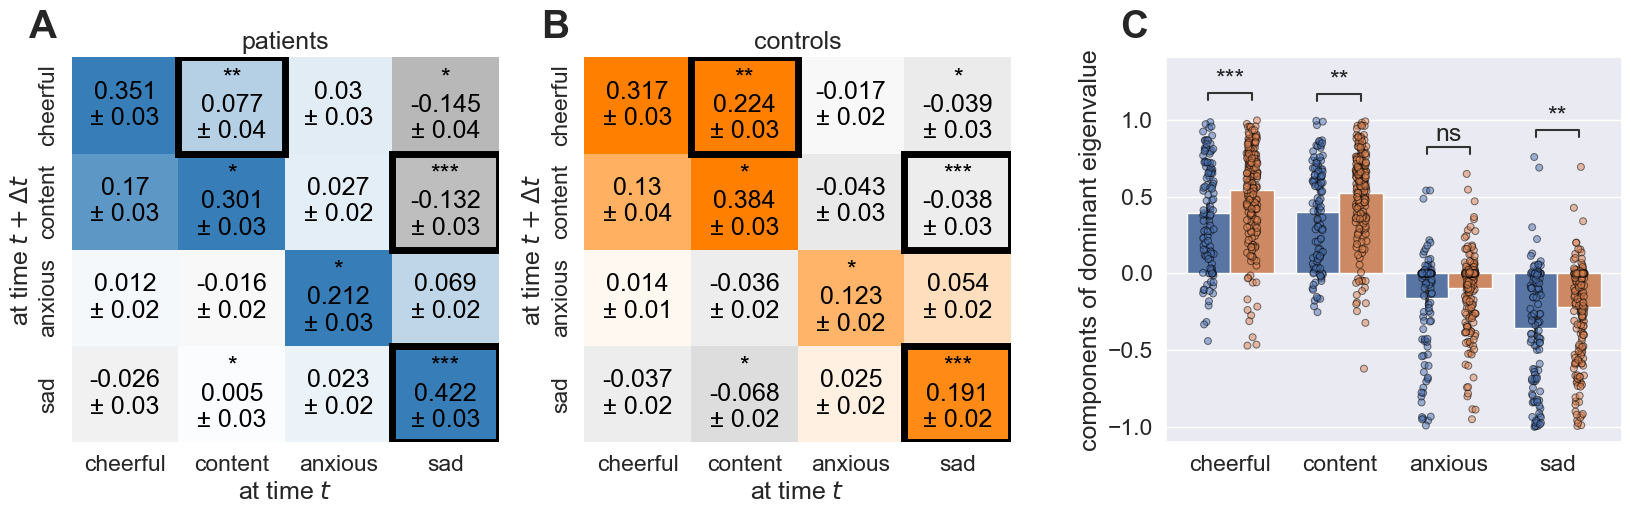

In [17]:
# Plot matrix and eigenvector differences 
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(20,5))
outer = gridspec.GridSpec(1, 2, width_ratios = [2, 1], hspace = .05) 
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[0])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])

# Plot matrix for both groups
ax = [plt.subplot(gs1[0]), plt.subplot(gs1[1])]
opt_plot = dict()
opt_plot['fig'] = fig
opt_plot['ax'] = ax
opt_plot['xlabels'] = mood_columns
opt_plot['group_label'] = ['patients', 'controls']
opt_plot['cmap'] = [patients_shading, controls_shading]
opt_plot['color'] = group_color
opt_plot['parameteric'] = True
reshaped_matrix = np.real(dynamics['matrix_hour'].reshape(16, Nsj).copy())
[t,p] = scipy.stats.mannwhitneyu(reshaped_matrix[:,df_depression['group']==0].T, \
                              reshaped_matrix[:,df_depression['group']==1].T)
plotting.plot_dynamics_matrices_group(np.real(dynamics['matrix_hour'][:,:,:]), \
                                      df_depression['group'], p, opt_plot)
for i in range(2):
    ax[i].text(-0.1, 1.05, ['A', 'B'][i], transform=ax[i].transAxes, weight='bold', size=28)
    ax[i].set(ylabel='at time $t+\Delta t$', xlabel='at time $t$')

# Plot matrix eigenvectors
ax = plt.subplot(gs2[0])
opt_plot = dict()
opt_plot['fig'] = fig
opt_plot['xticklabels'] = mood_columns
opt_plot['xlabels'] = None
opt_plot['color'] = group_color
opt_plot['group_label'] = ['patients', 'controls']
opt_plot['ax'] = plt.subplot(1,3,3)
opt_plot['ylabel'] = 'dominant eigenvalue loading'
data_plot = pd.melt(pd.concat((df_depression['group'],\
                               pd.DataFrame((dynamics['vec_aligned'][:,0,:]), \
                                            index=mood_columns).T),axis=1),id_vars='group')
hue_plot_params = {
        'data': data_plot,
        'x': 'variable',
        'y': 'value',
        "hue": "group",}

b = sns.barplot(**hue_plot_params)
sns.stripplot(**hue_plot_params, dodge=True, alpha=0.5,\
              edgecolor="black", linewidth=.75)
pairs = []
for i in mood_columns:
    pairs.append([(i, 0), (i, 1)])

annotator = Annotator(b, pairs, **hue_plot_params);
annotator.configure(verbose=0, test='Mann-Whitney', comparisons_correction='HB')
annotator.apply_and_annotate()
b.legend([],[],frameon=False)
if i == 0: 
    l = b.legend(loc=(0.765, 1.02))
    for j,i in enumerate(opt_plot['group_label']):
        l.get_texts()[j].set_text(i)
b.set(ylabel='components of dominant eigenvalue', xlabel='')
b.text(-0.1, 1.05, 'C', transform=b.transAxes, weight='bold', size=28);
if savefig: plt.savefig(figpath + 'malamud_fig5_dynamicsComparison.svg', bbox_inches='tight')

In [18]:
# Regression between dynamic features and depression score separate for both groups
score ='dep1_zscore'
df_reg_dynamics = pd.DataFrame()
for g in range(2):
    group_tmp = pd.DataFrame()
    for parameter in [dynamics['val'], np.abs(dynamics['vec'][:,0,:]), basic_char['variance'], \
                      basic_char['RMSSD'], basic_char['AR'], basic_char['mean']]:
        
        tmp = stats.depression_relations(parameter[:,df_depression['group']==g], df_depression[score][df_depression['group']==g], \
                                ['rspear', 'pvalue'], mood_columns)
        
        group_tmp = pd.concat((group_tmp,tmp),axis=0)

    df_reg_dynamics = pd.concat((df_reg_dynamics,group_tmp),axis=1)
    
header = [np.repeat(np.array(['patients', 'controls']),len(df_reg_dynamics.columns.unique())), \
          np.array(len(['patients', 'controls'])*['rspear', 'pvalue']).flatten()]
df_reg_dynamics.columns = header
index_header = [np.concatenate((np.repeat(np.array(parameter_labels[0]),4),np.repeat(np.array(parameter_labels[1:]),4))), 
                    np.concatenate((np.array(['1st', '2nd', '3rd', '4th']), \
                                    np.array(len(parameter_labels[1:])*mood_columns)))]
df_reg_dynamics.index = index_header
display(df_reg_dynamics)
# print(df_reg_matrix.to_latex(escape=False))

patients        controls          
                               rspear pvalue   rspear    pvalue
eigenvalues         1st          0.12    0.3     0.27  $<$0.001
                    2nd          0.10  0.368     0.35  $<$0.001
                    3rd          0.13  0.233     0.44  $<$0.001
                    4th          0.20  0.081     0.45  $<$0.001
slowest eigenvector cheerful    -0.10  0.356    -0.22     0.001
                    content     -0.16  0.167    -0.18     0.008
                    anxious      0.15  0.188     0.30  $<$0.001
                    sad          0.06  0.601     0.45  $<$0.001
variabilty          cheerful    -0.04  0.753     0.28  $<$0.001
                    content     -0.05  0.678     0.18     0.011
                    anxious      0.22  0.055     0.41  $<$0.001
                    sad          0.17  0.127     0.54  $<$0.001
instability         cheerful     0.01  0.916    -0.01     0.927
                    content     -0.10  0.362    -0.08      0.24
                    anxious      0.03  0.794    -0.03     0.637
                    sad          0.00  0.981     0.00      0.99
inertia             cheerful    -0.05  0.646     0.09     0.179
                    content     -0.10  0.377     0.07     0.295
                    anxious     -0.05    0.7     0.13     0.114
                    sad          0.16  0.163     0.23     0.004
mean                cheerful    -0.17  0.138    -0.25  $<$0.001
                    content     -0.19  0.099    -0.32  $<$0.001
                    anxious      0.22  0.049     0.44  $<$0.001
                    sad          0.23  0.042     0.57  $<$0.001

# Supplementary plots

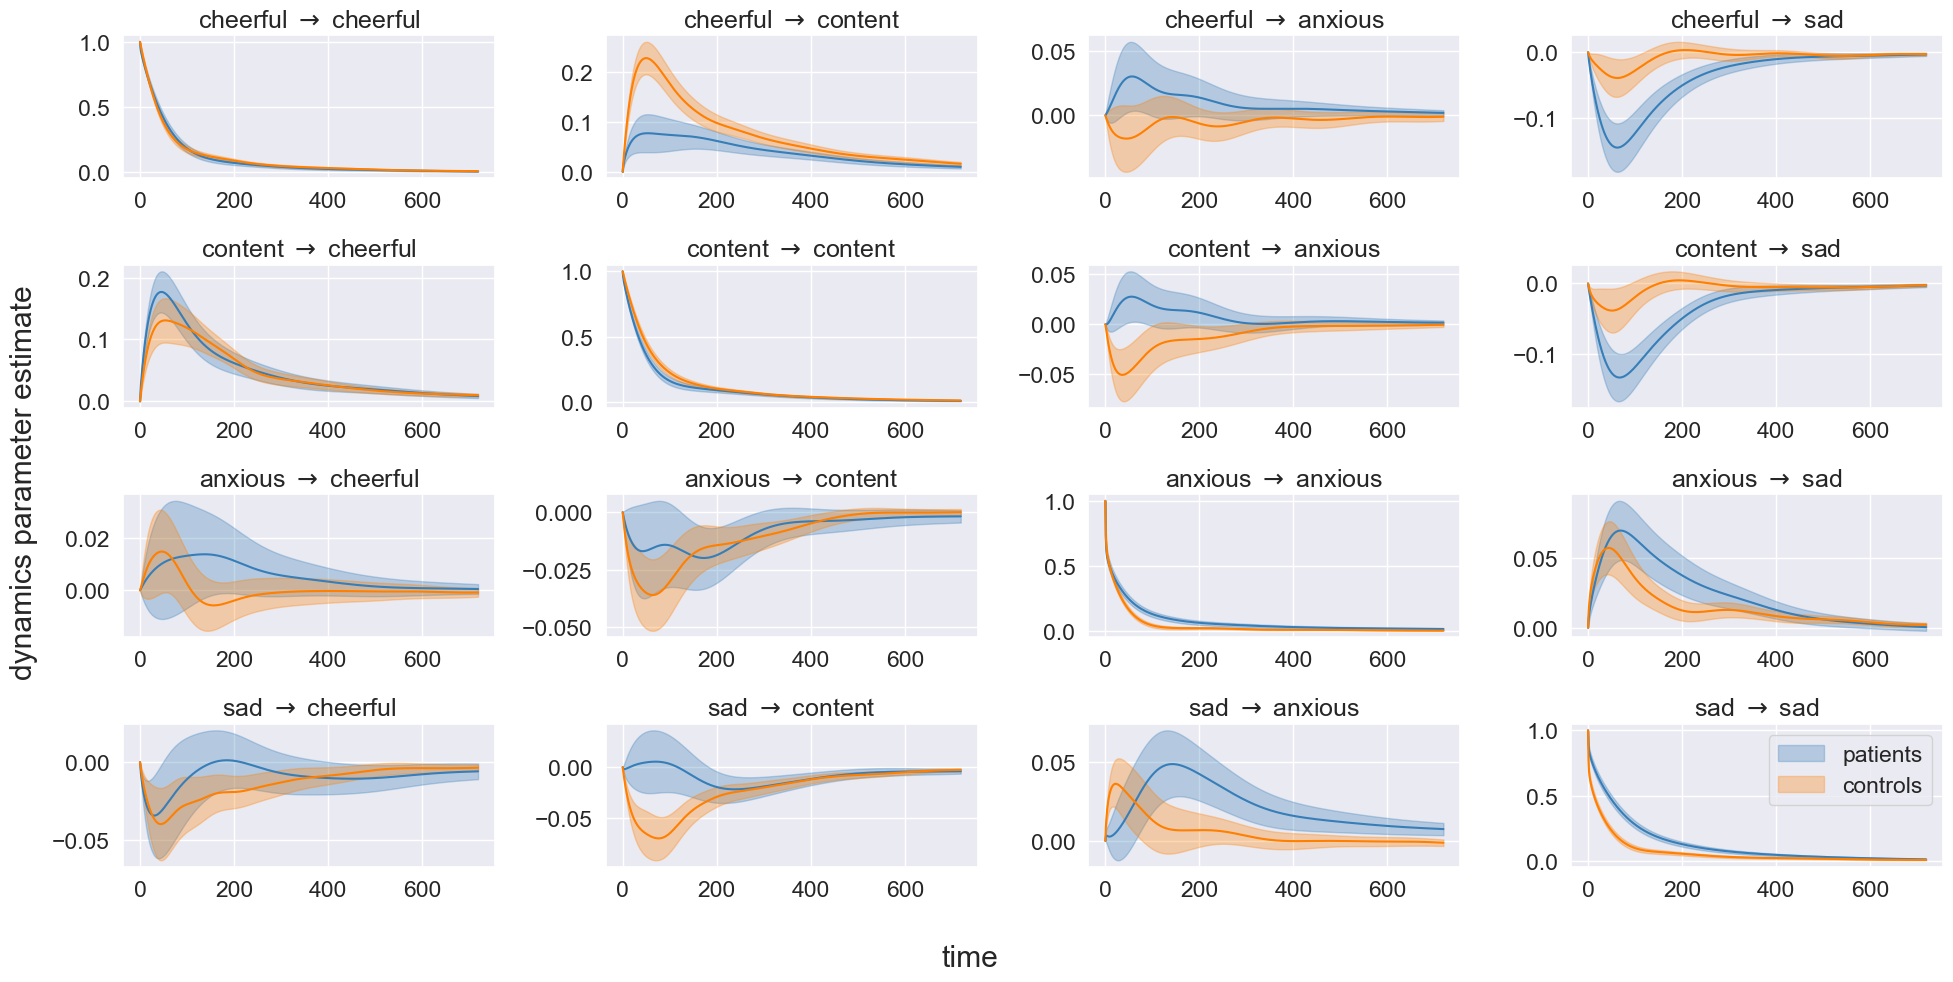

In [19]:
# Dynamics evolving over time
dynamics['matrix_overTime'] = np.full((4,4,Nsj,12*60), np.nan)
for i in range(Nsj):
    for t in range(12*60):
        dynamics['matrix_overTime'][:,:,i,t] = np.linalg.matrix_power(data[i]['A'],t)
        
fig,axs = plt.subplots(4,4, figsize=(20,10))
for g in range(2):
    for i in range(4):
        for j in range(4): 
            meanst = np.nanmean(dynamics['matrix_overTime'][i,j,df_depression['group']==g,:],axis=0)
            sdt= np.nanstd(dynamics['matrix_overTime'][i,j,df_depression['group']==g,:],axis=0) \
                    / np.sqrt(sum(df_depression['group']==g))
            axs[i,j].plot(range(12*60), meanst, color=group_color[g], label='_nolegend_')
            axs[i,j].fill_between(range(12*60), meanst-sdt, meanst+sdt ,alpha=0.3, color=group_color[g])
            axs[i,j].set_title(mood_columns[i] + r' $\rightarrow$ ' + mood_columns[j])
fig.supxlabel('time')
fig.supylabel('dynamics parameter estimate')
plt.legend(['patients','controls']);
fig.tight_layout()
if savefig: plt.savefig(figpath + 'supp_fig1_Aovertime.svg', bbox_inches='tight')

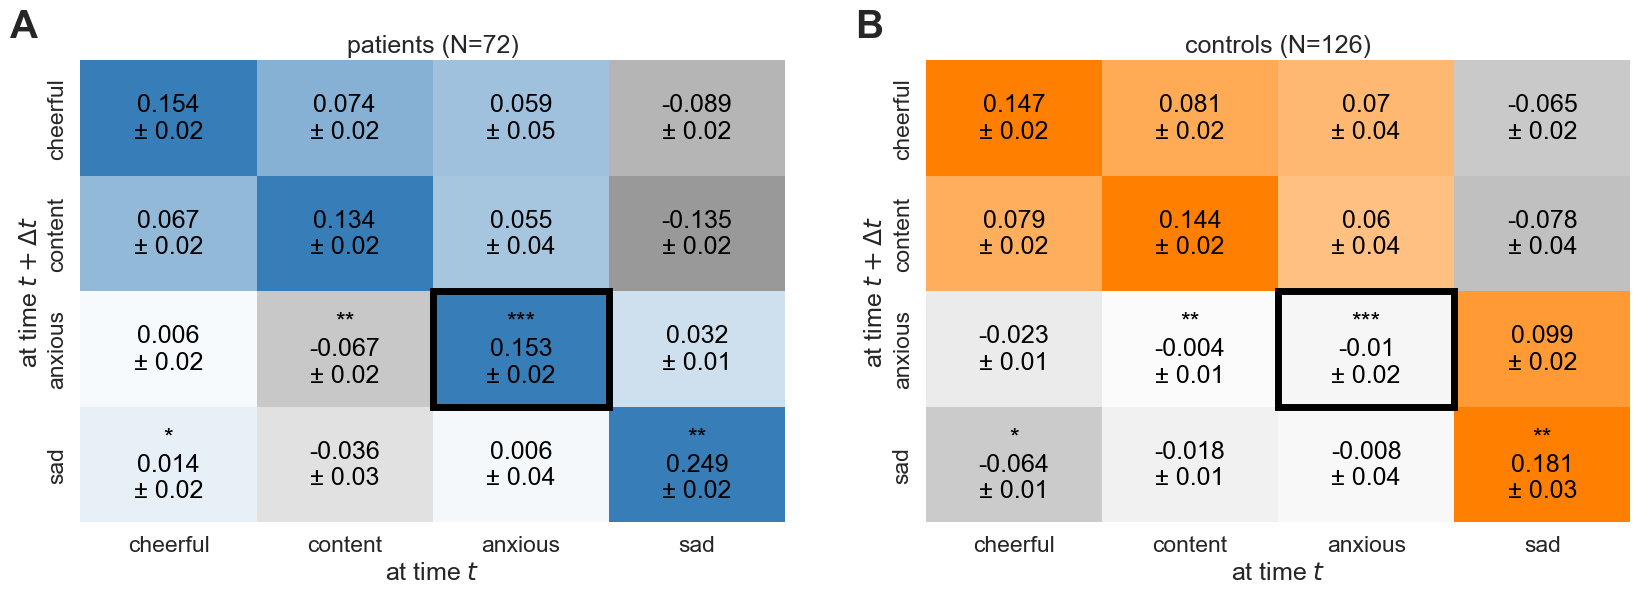

In [20]:
# Plot average VAR matrix for patients and control including statistics
opt_plot = dict()
var_nans = np.isnan(dynamics['VAR'][0,0,:])
sns.set(font_scale=1.5)
fig,ax = plt.subplots(1,2, figsize=(20,6))
opt_plot['fig'] = fig
opt_plot['ax'] = ax
opt_plot['xlabels'] = mood_columns
opt_plot['group_label'] = ['patients (N=' + str((df_depression['group'][~var_nans]==0).sum()) + ')', \
                           'controls (N=' + str((df_depression['group'][~var_nans]==1).sum()) + ')']
opt_plot['cmap'] = [patients_shading, controls_shading]
opt_plot['color'] = group_color
opt_plot['parameteric'] = True
parameter = np.reshape(dynamics['VAR'], (16, Nsj))
idx = ~np.isnan(parameter).any(axis=0)
foo, pvalues = scipy.stats.mannwhitneyu(parameter[:,(df_depression['group']==0)&idx].T, \
                              parameter[:,(df_depression['group']==1)&idx].T)
plotting.plot_dynamics_matrices_group(np.real(dynamics['VAR']), df_depression['group'], pvalues, opt_plot)
for i in range(2):
    ax[i].text(-0.1, 1.05, ['A', 'B'][i], transform=ax[i].transAxes, weight='bold', size=28)
    ax[i].set(ylabel='at time $t+\Delta t$', xlabel='at time $t$')
if savefig: plt.savefig(figpath + 'supp_fig2_VARmatrixComparison.svg')

In [21]:
# Table of group difference of VAR matrix elements
parameter = np.reshape(dynamics['VAR'], (16, Nsj))
df_stats_dynamics = stats.group_difference_table(parameter, df_depression, 'MWU', \
                       ['patients (M ± SD)', 'controls (M ± SD)', 'U', 'pvalue'], A_columns_idx)

display(df_stats_dynamics)
# print(df_stats_dynamics.to_latex(escape=False))

multiple comparison: p<0.025


,patients (M ± SD),controls (M ± SD),U,pvalue
cheerful $\rightarrow$ cheerful (a$_{11}$),0.15 ± 0.23,0.15 ± 0.24,4579.0,0.913
content $\rightarrow$ cheerful (a$_{12}$),0.07 ± 0.23,0.08 ± 0.23,4516.0,0.96
anxious $\rightarrow$ cheerful (a$_{13}$),0.06 ± 0.57,0.07 ± 0.53,4054.0,0.214
sad $\rightarrow$ cheerful (a$_{14}$),-0.09 ± 0.22,-0.06 ± 0.36,4456.0,0.838
cheerful $\rightarrow$ content (a$_{21}$),0.07 ± 0.23,0.08 ± 0.26,4416.0,0.758
content $\rightarrow$ content (a$_{22}$),0.13 ± 0.23,0.14 ± 0.25,4407.0,0.74
anxious $\rightarrow$ content (a$_{23}$),0.05 ± 0.43,0.06 ± 0.65,4397.0,0.721
sad $\rightarrow$ content (a$_{24}$),-0.13 ± 0.27,-0.08 ± 0.54,3914.0,0.109
cheerful $\rightarrow$ anxious (a$_{31}$),0.01 ± 0.22,-0.02 ± 0.15,4986.0,0.247
content $\rightarrow$ anxious (a$_{32}$),-0.07 ± 0.25,-0.0 ± 0.16,3458.0,0.005


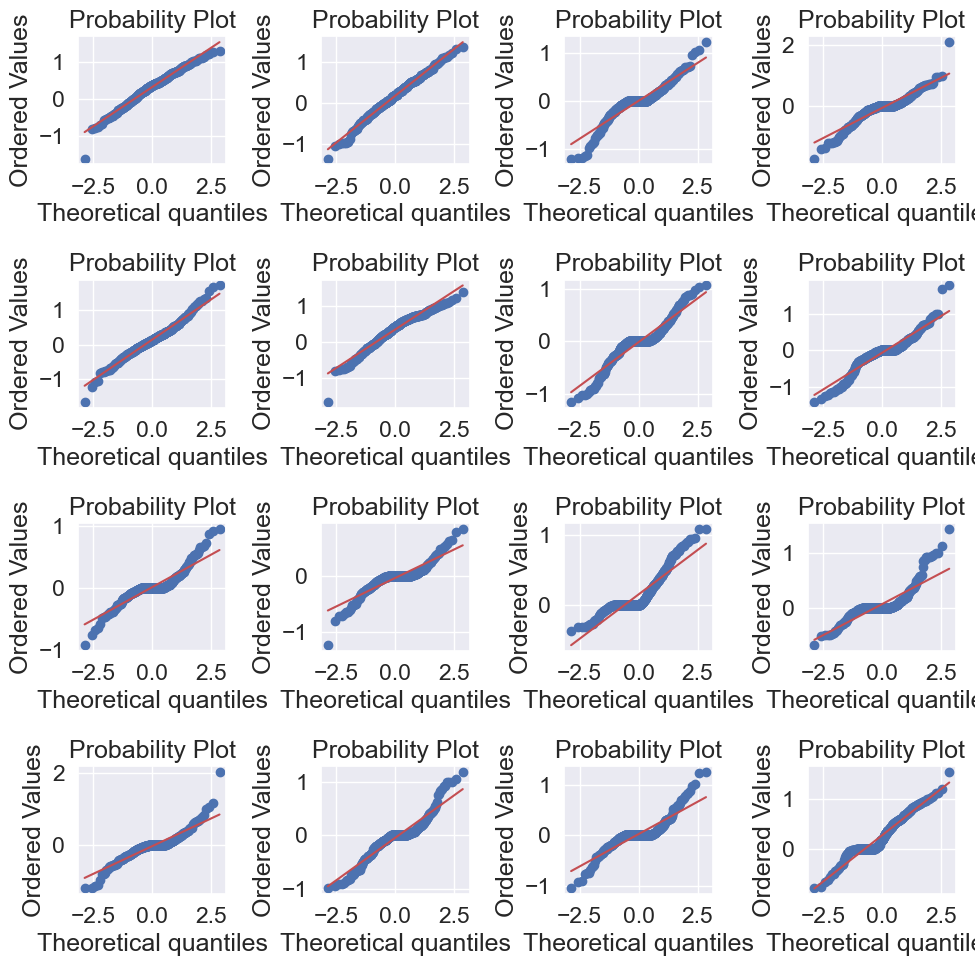

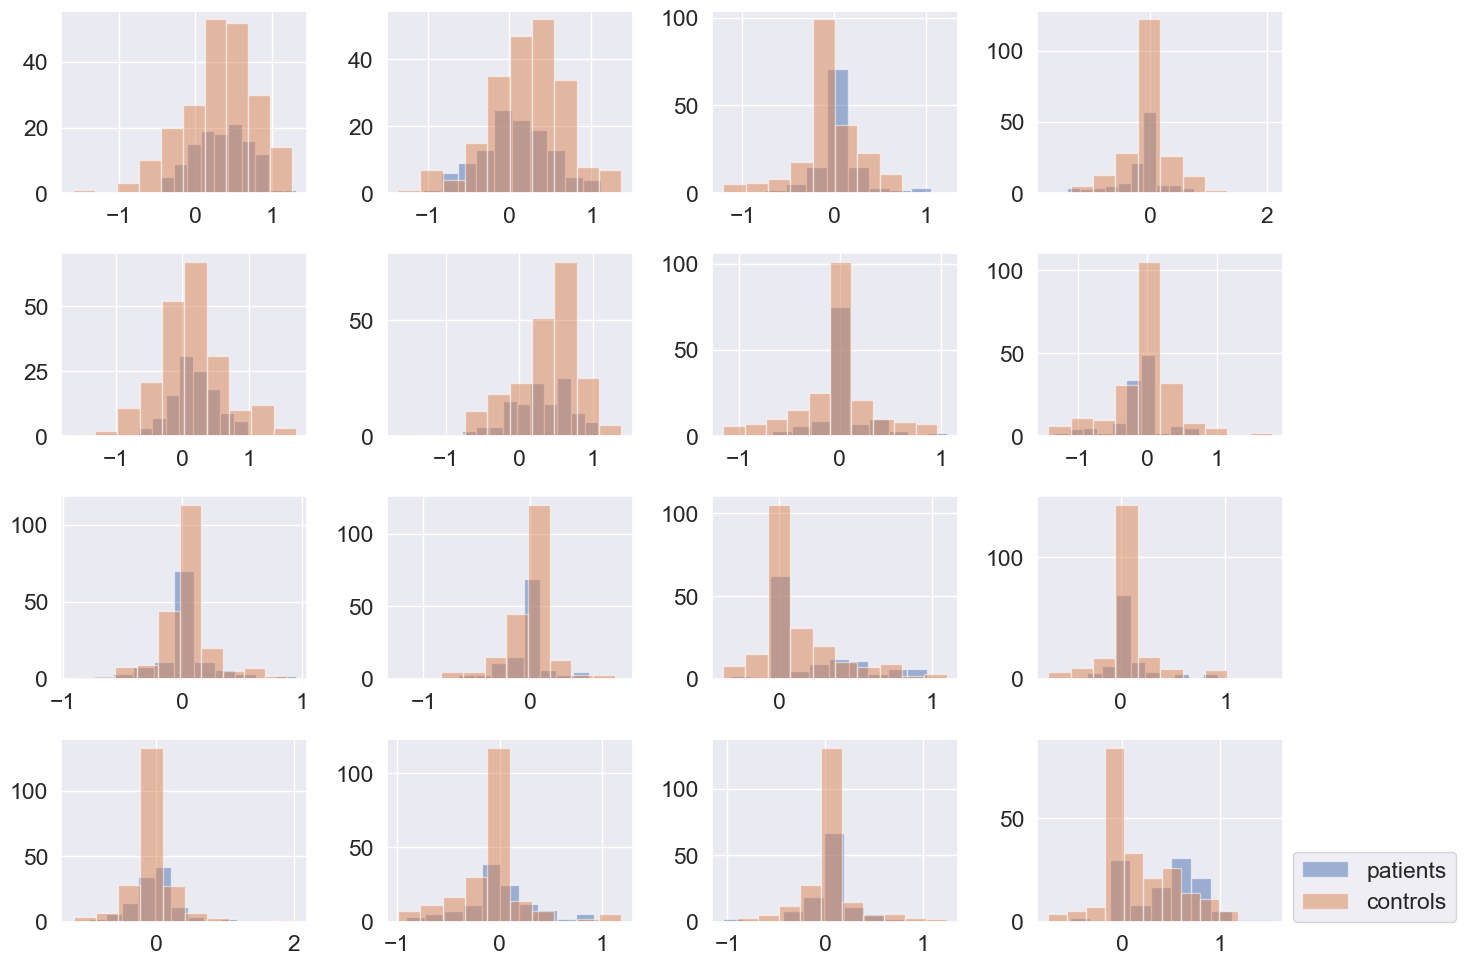

In [22]:
# Supplement figure normality of dynamics matrix
fig,axs = plt.subplots(4,4,figsize=(10,10))
for i in range(4):
    for j in range(4):
        scipy.stats.probplot((dynamics['matrix_hour'][i,j,:]), plot=axs[i,j])
plt.tight_layout()
fig,axs = plt.subplots(4,4,figsize=(15,10))
for i in range(4):
    for j in range(4):
        for k in range(2):
            axs[i,j].hist((dynamics['matrix_hour'][i,j,df_depression['group']==k]), alpha=0.5)
axs[i,j].legend(['patients', 'controls'],loc=(1.04,0));
plt.tight_layout()